### Step 1: Import Liabraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import re
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os
os.chdir('Desktop')

In [3]:
data = pd.read_csv('Default_Fin.csv')

In [4]:
data.head()

,Index,Employed,Bank Balance,Annual Salary,Defaulted?
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0


In [5]:
data.shape

(10000, 5)

This dataset contains 100000 rows and 5 columns with below explaination by column.

Employed: 1 for employed and 0 for unemployed;

Bank Balance: Bank balance of individual in their account

Annual Salary: Annual salary of each client

Defaulted?: This is our dependent variable, 0 represent not defaulter and 1 represent defaulter.



### Step 2: Exploratory Data Analysis

In [6]:
data.isnull().sum()

Index            0
Employed         0
Bank Balance     0
Annual Salary    0
Defaulted?       0
dtype: int64

<AxesSubplot:>

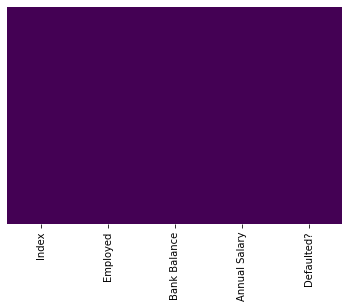

In [7]:
sns.heatmap(data.isnull(), yticklabels=False,cbar=False,cmap='viridis')

#### We don't have null values in the dataset

In [8]:
# Renaming defaulted column from defaulted? to defaulted
data.rename({'Defaulted?':'Defaulted'}, axis = 1, inplace = True)
data

,Index,Employed,Bank Balance,Annual Salary,Defaulted
0,1,1,8754.36,532339.56,0
1,2,0,9806.16,145273.56,0
2,3,1,12882.60,381205.68,0
3,4,1,6351.00,428453.88,0
4,5,1,9427.92,461562.00,0
...,...,...,...,...,...
9995,9996,1,8538.72,635908.56,0
9996,9997,1,9095.52,235928.64,0
9997,9998,1,10144.92,703633.92,0
9998,9999,1,18828.12,440029.32,0


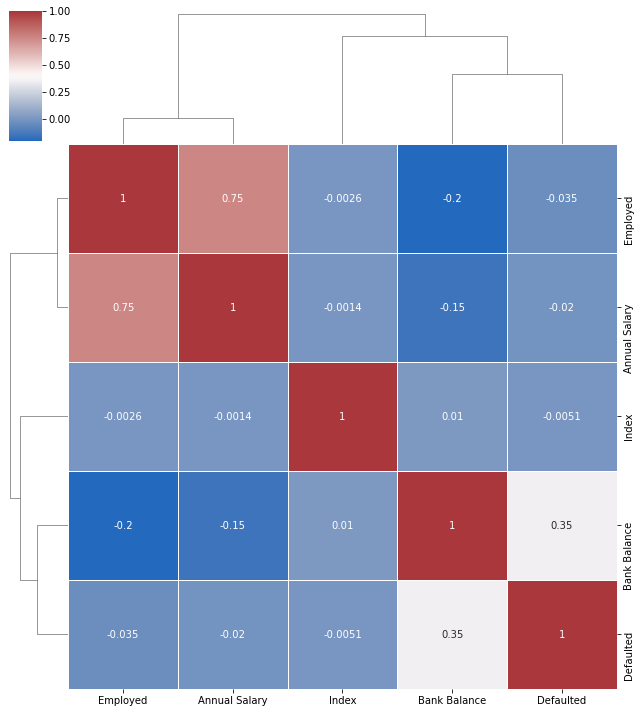

In [9]:
sns.clustermap(data.corr(), cmap = "vlag", dendrogram_ratio = (0.1, 0.2), annot = True, linewidths = .8, figsize = (9,10))
plt.show()

We can see each variable is correlated with each other

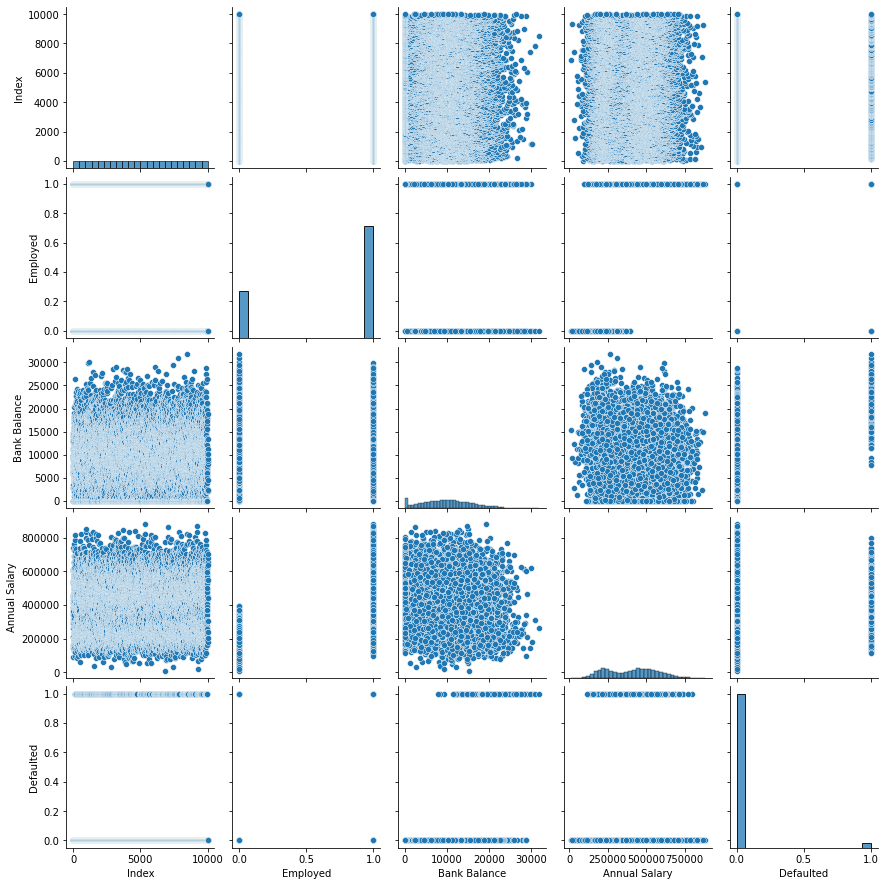

In [10]:
sns.pairplot(data)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Defaulted', ylabel='Density'>

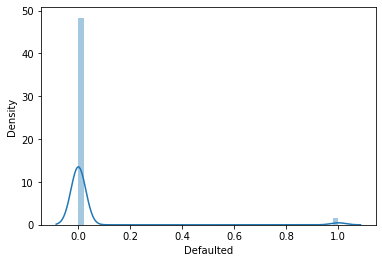

In [11]:
sns.distplot(data['Defaulted'])

<AxesSubplot:xlabel='Defaulted'>

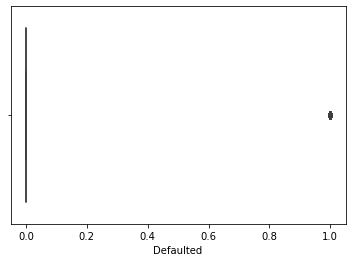

In [12]:
sns.boxplot(x=data["Defaulted"])

<AxesSubplot:xlabel='Defaulted', ylabel='count'>

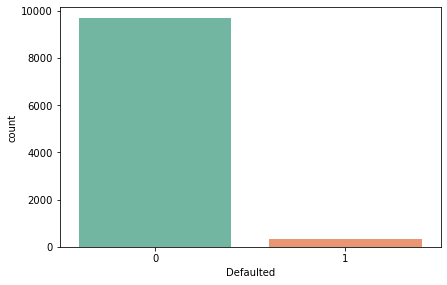

In [13]:
plt.figure(figsize = (15,15))

plt.subplot(3,2,1)
sns.countplot(x = 'Defaulted', palette = 'Set2', data = data)


### Based on above charts it clearly shows Loan defaulter count is very less compared to non defaulter

<AxesSubplot:>

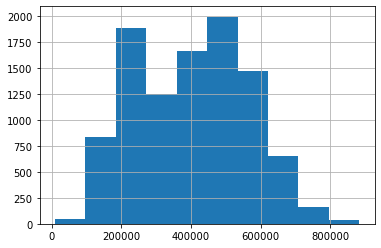

In [14]:
data["Annual Salary"].hist()

<AxesSubplot:>

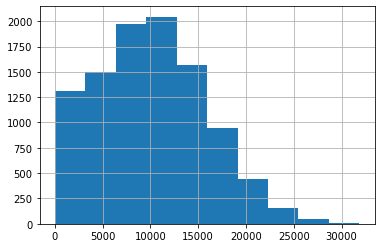

In [15]:
data["Bank Balance"].hist()

<AxesSubplot:>

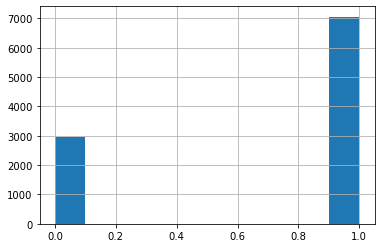

In [16]:
data["Employed"].hist()

In [17]:
group = data.groupby(["Employed", "Defaulted"], as_index=False)
group.mean()

,Employed,Defaulted,Index,Bank Balance,Annual Salary
0,0,0,5022.116791,11381.762386,215244.105218
1,0,1,4790.039370,22324.546772,218922.098268
2,1,0,4995.492701,8934.053396,479922.182050
3,1,1,5001.150485,20141.152427,487500.603495


Based on above explaination we can say that Unemployed people have higher mean Bank Balance and Lower Annual salary with unemployed defaulters having the highest bank balance.

<AxesSubplot:xlabel='Defaulted', ylabel='Bank Balance'>

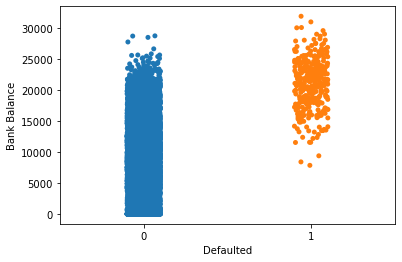

In [18]:
sns.stripplot(data=data, x="Defaulted", y="Bank Balance")

<AxesSubplot:xlabel='Defaulted', ylabel='Annual Salary'>

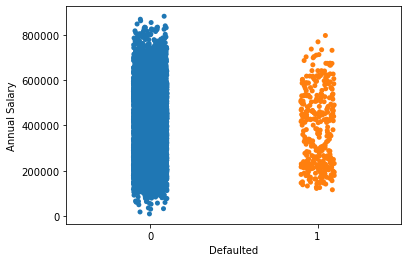

In [19]:
sns.stripplot(data=data, x="Defaulted", y="Annual Salary")

### Index column not required for model prediction so let's drop it

In [20]:
data = data.drop(['Index'], axis = 1)
data.head()

,Employed,Bank Balance,Annual Salary,Defaulted
0,1,8754.36,532339.56,0
1,0,9806.16,145273.56,0
2,1,12882.60,381205.68,0
3,1,6351.00,428453.88,0
4,1,9427.92,461562.00,0


In [21]:
data.describe()

,Employed,Bank Balance,Annual Salary,Defaulted
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.705600,10024.498524,402203.782224,0.033300
std,0.455795,5804.579486,160039.674988,0.179428
min,0.000000,0.000000,9263.640000,0.000000
25%,0.000000,5780.790000,256085.520000,0.000000
50%,1.000000,9883.620000,414631.740000,0.000000
75%,1.000000,13995.660000,525692.760000,0.000000
max,1.000000,31851.840000,882650.760000,1.000000


If we check Bank Balance and Annual Salary columns they have high variance between min and Max values let's convert them into model reading binary scale by using feature scaling method

In [22]:
feature_cols = ['Employed', 'Bank Balance', 'Annual Salary']

''' Normalize the distribution. '''
scaler = MinMaxScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])

In [23]:
data.head()

,Employed,Bank Balance,Annual Salary,Defaulted
0,1.0,0.274846,0.598905,0
1,0.0,0.307868,0.155727,0
2,1.0,0.404454,0.425862,0
3,1.0,0.199392,0.479959,0
4,1.0,0.295993,0.517867,0


### Step 3: Model Buiding

### Model 1: Logistic Regression

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score

X = data.iloc[:, :-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
 
predictions = logmodel.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2909
           1       0.84      0.23      0.36        91

    accuracy                           0.98      3000
   macro avg       0.91      0.61      0.67      3000
weighted avg       0.97      0.98      0.97      3000

[[2905    4]
 [  70   21]]
0.9753333333333334


### Model 2: K-Nearest_Neighbours

In [25]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.2, random_state=42)
  
knn = KNeighborsClassifier(n_neighbors=7)
  
knn.fit(X_train, y_train)
  
# Predict on dataset which model has not seen before
print(knn.predict(X_test))

[0 0 0 ... 0 0 0]


In [26]:
knn = KNeighborsClassifier(n_neighbors=7)
  
knn.fit(X_train, y_train)
  
# Calculate the accuracy of the model
print(knn.score(X_test, y_test))

0.967


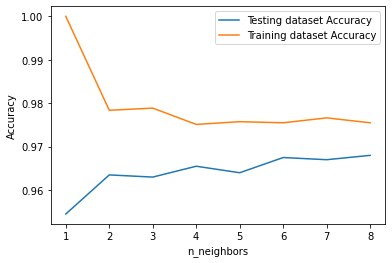

In [27]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
  
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
      
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
  
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

### Model 3: Random Forest

In [28]:
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=2022, oob_score=True)
param_dist = {"n_estimators": [50, 100, 150, 200, 250],
              'min_samples_leaf': [1, 2, 4]}
rfc_gs = GridSearchCV(clf, param_grid=param_dist, scoring='accuracy', cv=5)
rfc_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=2022),
             param_grid={'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 150, 200, 250]},
             scoring='accuracy')

In [29]:
rfc_gs.best_score_

0.9721249999999999

### Model 4: Decision Tree

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
clf = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))])

criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9, 10, 11, 15, 20, 25]
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None]

param_grid =\
    [{'clf__class_weight': class_weight,
      'clf__criterion': criterion,
      'clf__splitter': splitter,
      'clf__max_depth': max_depth,
      'clf__min_samples_leaf': min_samples_leaf
      }]

gs_dt = GridSearchCV(estimator=clf, param_grid=param_grid,
                     scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf__class_weight': ['balanced', None],
                          'clf__criterion': ['gini', 'entropy'],
                          'clf__max_depth': [8, 9, 10, 11, 15, 20, 25],
                          'clf__min_samples_leaf': [2, 3, 5],
                          'clf__splitter': ['best']}],
             scoring='accuracy', verbose=1)

In [31]:
print(gs_dt.best_score_)

0.96975


### Model 5: Support Vector Machine (SVM)

In [32]:
# Normalize the  data (center around 0 and scale to remove the variance).
scaler =StandardScaler()
Xs = scaler.fit_transform(X)

In [33]:
# Divide records in training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=2, stratify=y)

# Create an SVM classifier and train it on 70% of the data set.
clf = SVC(probability=True)
clf.fit(X_train, y_train)

# Analyze accuracy of predictions on 30% of the holdout test sample.
classifier_score = clf.score(X_test, y_test)
print ('\n➔ The classifier accuracy score is {:03.2f}\n'.format(classifier_score))


➔ The classifier accuracy score is 0.97



### Model 6: Naive Bayes

In [34]:
import csv
import math
import random

In [35]:
from sklearn.naive_bayes import GaussianNB
nv = GaussianNB() # create a classifier
nv.fit(X_train,y_train) # fitting the data

GaussianNB()

In [36]:
from sklearn.metrics import accuracy_score
y_pred = nv.predict(X_test) # store the prediction data
accuracy_score(y_test,y_pred) # calculate the accuracy

0.9686666666666667

### Model 7: AdaBoost Classifier

In [37]:
from sklearn.ensemble import AdaBoostClassifier
a_model = AdaBoostClassifier()
a_model.fit(X_train,y_train)
a_preds = a_model.predict(X_test)
print("AdaBoost Classifier accuracy")

AdaBoost Classifier accuracy


In [38]:
print(classification_report(y_test, a_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2900
           1       0.53      0.38      0.44       100

    accuracy                           0.97      3000
   macro avg       0.75      0.68      0.71      3000
weighted avg       0.96      0.97      0.97      3000



### Model 8: GradientBoost Classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print("Gradient Boosting Classifier", accuracy_score(y_test, gb_pred))

Gradient Boosting Classifier 0.9633333333333334


In [41]:
print(classification_report(y_test, a_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2900
           1       0.53      0.38      0.44       100

    accuracy                           0.97      3000
   macro avg       0.75      0.68      0.71      3000
weighted avg       0.96      0.97      0.97      3000



### Model 9: K Fold Cross Validation

In [51]:
# Applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier,X= X,y = y,cv = 20)# 10 fold times test data is validated
print(accuracies.mean())

0.9679


### Model Summary 

#### Logistic Regression - 98 
#### KNN - 96.70 
#### Random Forest - 97.21
#### Decision Tree- 96.97
#### SVM- 97
#### Naive Bayes- 96.86
#### AdaBoost - 97
#### Gradient Boost - 97
#### K Fold Cross Validation - 96.79


### Conclusion: I have applied total 9 models on this dataset and almost all models have accuracy score between 96% to 98% which is really good, Logistic Regression model have high accuracy which is 98%